## RCNN

In [1]:
from ipynb.fs.full.general_functions import *

import mrcnn.rcnn_rbc_config as rbc_config
import mrcnn.utils
import tensorflow as tf
import mrcnn.model as modellib


class RCNNModels:
    model_512 = None
    model_256 = None
    
    def load(model, version, file):
        if (version == 256):
            RCNNModels.__load(model,file)
            RCNNModels.model_256 = model
        else:
            RCNNModels.__load(model,file)
            RCNNModels.model_512 = model
            
    def __load(model, file):
        print("Carrega:", file)
        if os.path.isfile("mrcnn/"+file):
            model.load_weights('mrcnn/'+file, by_name=True)
        else:
            model.load_weights('segmentation_methods/mrcnn/'+file, by_name=True)
            

2.4.1
2.4.0


Instructions for updating:
Use fn_output_signature instead
Carrega: mask_rcnn_rbc_0020.h5


c:\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


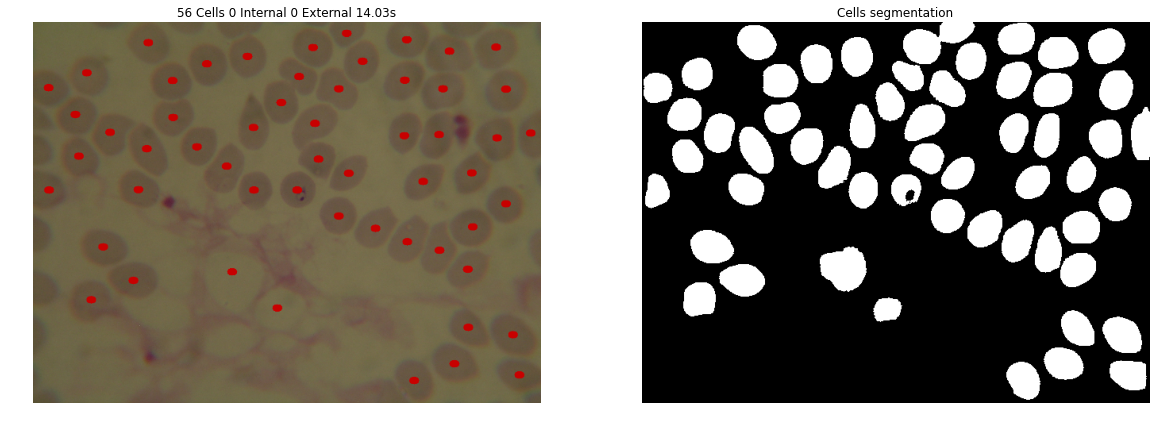

In [2]:



def rcnn_method(path, validation_type, mark_parasites=True, trainVersion=1):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    
    #read in colors
    img = get_image(path=path,mode=1,size=(1024,1024))
    
    config = rbc_config.RBCInferenceConfig()
    #config.display()
    
    
    DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

    
    # Create model in inference mode
    with tf.device(DEVICE):
        model = modellib.MaskRCNN(mode="inference", model_dir=".",config=config)
        
    
    if trainVersion == 0:
        if RCNNModels.model_256 == None:
            RCNNModels.load(model,256,"mask_rcnn_rbc_0020.h5")
        else:
            model = RCNNModels.model_256
    else:
        if RCNNModels.model_512 == None:
            RCNNModels.load(model,512,"mask_rcnn_rbc_512-e1000.h5")
        else:
            model = RCNNModels.model_512
    
    
    molded_images, image_metas, windows = model.mold_inputs([img])

    results = model.detect_molded(np.expand_dims(molded_images[0], 0), np.expand_dims(image_metas[0], 0), verbose=0)
        
    #faz as marcacoes com circulos vermelhos
    r = results[0]
    for box in r['rois']:
        y, x, y2, x2 = box //2
        w, h = x2-x, y2-y

        img = cv2.circle(img, (x+w//2,y+h//2), 10, (200,0,0), -1)

    #gera a mascara das celulas
    cells = 0
    cell_mask = np.zeros_like(r['masks'][:,:,0])
    for i in range(len(r['masks'][0][0])):
        mask = r['masks'][:,:,i]
        cells += 1
        cell_mask = np.ma.mask_or(cell_mask,r['masks'][:,:,i])
    cell_mask = cell_mask.astype(np.uint8)
    
    
    name = "RCNN"
    method_ext = "_rcnn"
    
    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    
    
    #Marca os parasitas
    cell_mask = cv2.resize(cell_mask,(640,480))
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask, cell_mask)
    else:
        internal, external = 0,0
        
    end = time.time()
    
    img = cv2.resize(img, (640,480))
    cell_mask = cv2.resize(cell_mask, (640,480))

    passTime = "%.2fs" % (end-start)

    #save results
    save_results(path,name,cells,internal,external, passTime, img, method_ext, validation_type)
    
    return (img, cell_mask), (cells, internal, external, passTime)


if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_29.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = rcnn_method(PATH, NO_VALIDATION, mark_parasites=False, trainVersion=0)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

Carrega: mask_rcnn_rbc_512-e1000.h5


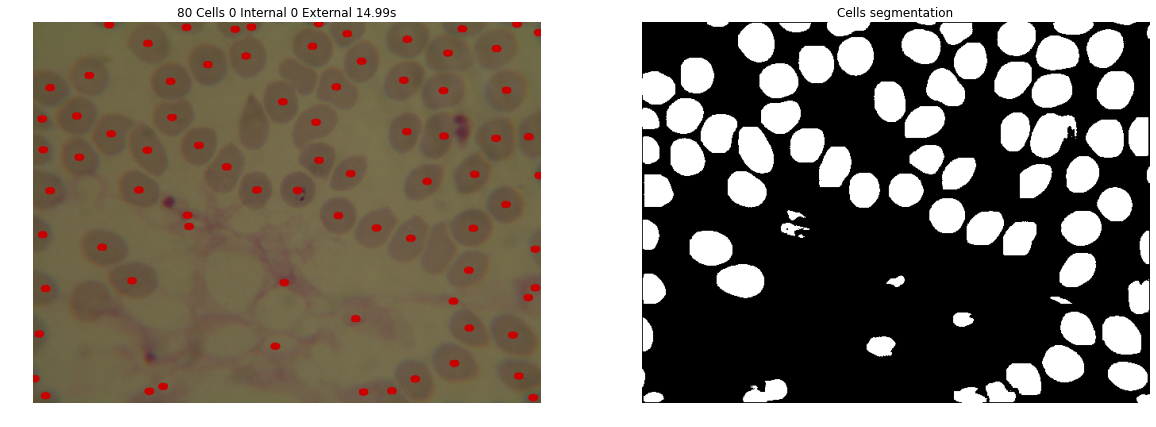

In [3]:

if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_29.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = rcnn_method(PATH, NO_VALIDATION, mark_parasites=False, trainVersion=1)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

In [4]:

if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_29.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    PATH = '../blood_samples/samples/blood_smear_15.JPG'
    images, stats = rcnn_method(PATH, NO_VALIDATION, mark_parasites=False, trainVersion=1)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

IndexError: index 0 is out of bounds for axis 2 with size 0